## To-do list:
* after-pulse calibration
* save calibration results in files:
    * breakdown voltage and gain at any voltage
    * after-pulse and crosstalk
    * spe pulse shape time constants and coefficients
* exponential background
* implement merge dataset
* analyze 1007 data

# Theoretical Beta Spectra of $^{90}\rm Sr$/$^{90}\rm Y$
Ref: https://academic.oup.com/ptps/article-lookup/doi/10.1143/PTPS.26.1

$$P(E) = C(E) F(Z,E) p E (Q - T)^2$$
$$F(Z,E)=\frac{2(1+S)}{\Gamma(1+2S)^2} (2pR_N)^{2(S-1)} e^{\pi\eta} |\Gamma(S+i\eta)|^2$$
* $R_N=A^{1/3}\times1.2\rm fm$
* $S=\sqrt{1-\alpha^2 Z^2}$
* $\eta = \frac{\alpha Z E}{p}$
* $Q(^{90}\rm Sr) = 0.546\rm MeV$
* $Q(^{90}\rm Y) = 2.28\rm MeV$
* $C(E)$ is the shape factor
    * $C(E) = 1$ for allowed decays
    * $C(E) = \frac{1}{12}[(E_0-E)^2+(E^2-1)]$ for unique 1st forbidden decays where $E_0 = 1+Q$ (approx. $\alpha Z\ll 1$)
    * Exact $C(E)$ for U1F is Eq.2 of https://link.aps.org/doi/10.1103/PhysRev.82.48

## Response model
Use Poisson (asymptotically Gaussian) with excessive noise factor (ENF) $\gamma$
$$f_r(E,N_{pe}) = \frac{1}{\sqrt{2\pi N_{pe} \gamma}} \exp\left[-\frac{1}{2}\frac{(N_{pe}-E L_{y'})^2}{N_{pe}\gamma}\right]$$
where $L_{y'}$ is the gross light yield, which is equal to $L_y(1+K_{dup}) = \frac{L_y}{1-p}$ with $L_y$ being the true light yield and $p$ being the crosstalk probability. $p\simeq0.2$ at $5$ VoV.

Trigger efficiency model is
$$\varepsilon_{tr}(N_{pe}) = \frac{1}{2}\left[1+erf\left(\frac{N_{pe}-N_0}{B}\right)\right]$$


In [1]:
import numpy as np
import sipm.sipm as sipm
import sipm.dataset as ds
import sipm.beta as beta
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sipm.constants as const
plt.style.use('darkside')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

(1e-06, 0.1)

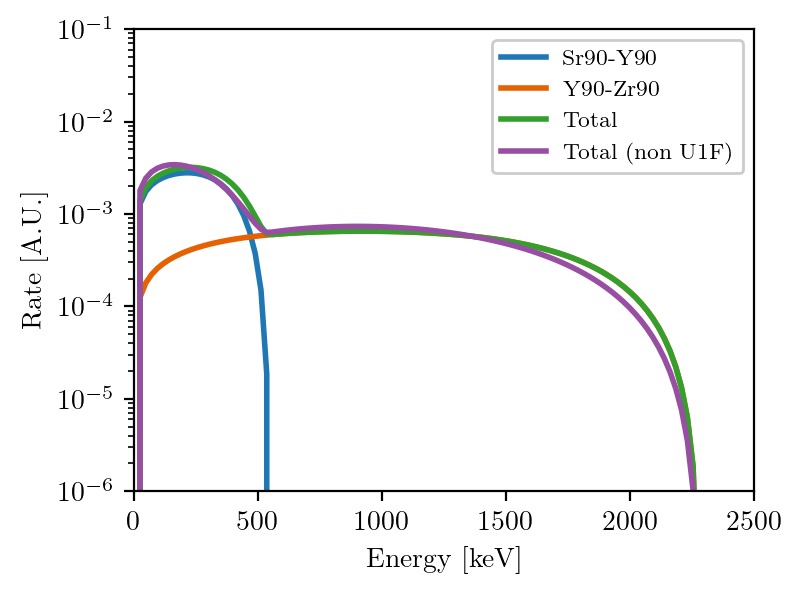

In [2]:
energy = np.linspace(0, 2300, 100)
norm_sr90, _ = beta.beta_shape_norm(Q=const.Q_SR90, Z=const.Z_Y90, A=const.A_SR90, u1f=True)
norm_y90, _ = beta.beta_shape_norm(Q=const.Q_Y90, Z=const.Z_ZR90, A=const.A_SR90, u1f=True)
norm_sr90_nu1f, _ = beta.beta_shape_norm(Q=const.Q_SR90, Z=const.Z_Y90, A=const.A_SR90, u1f=False)
norm_y90_nu1f, _ = beta.beta_shape_norm(Q=const.Q_Y90, Z=const.Z_ZR90, A=const.A_SR90, u1f=False)
plt.figure(0)
plt.plot(energy, [beta.beta_shape(T=energy_, Q=const.Q_SR90, C=1/norm_sr90, Z=const.Z_Y90, A=const.A_SR90, u1f=True) for energy_ in energy], label='Sr90-Y90')
plt.plot(energy, [beta.beta_shape(T=energy_, Q=const.Q_Y90, C=1/norm_y90, Z=const.Z_ZR90, A=const.A_SR90, u1f=True) for energy_ in energy], label='Y90-Zr90')
plt.plot(energy, [beta.beta_shape(T=energy_, Q=const.Q_SR90, C=1/norm_sr90, Z=const.Z_Y90, A=const.A_SR90, u1f=True)+beta.beta_shape(T=energy_, Q=const.Q_Y90, C=1/norm_y90, Z=const.Z_ZR90, A=const.A_SR90, u1f=True) for energy_ in energy], label='Total')
plt.plot(energy, [beta.beta_shape(T=energy_, Q=const.Q_SR90, C=1/norm_sr90_nu1f, Z=const.Z_Y90, A=const.A_SR90, u1f=False)+beta.beta_shape(T=energy_, Q=const.Q_Y90, C=1/norm_y90_nu1f, Z=const.Z_ZR90, A=const.A_SR90, u1f=False) for energy_ in energy], label='Total (non U1F)')
plt.legend(loc='upper right')
plt.xlabel('Energy [keV]')
plt.ylabel('Rate [A.U.]')
plt.yscale('log')
plt.ylim(1e-6, 1e-1)

Text(0, 0.5, 'Rate [A.U.]')

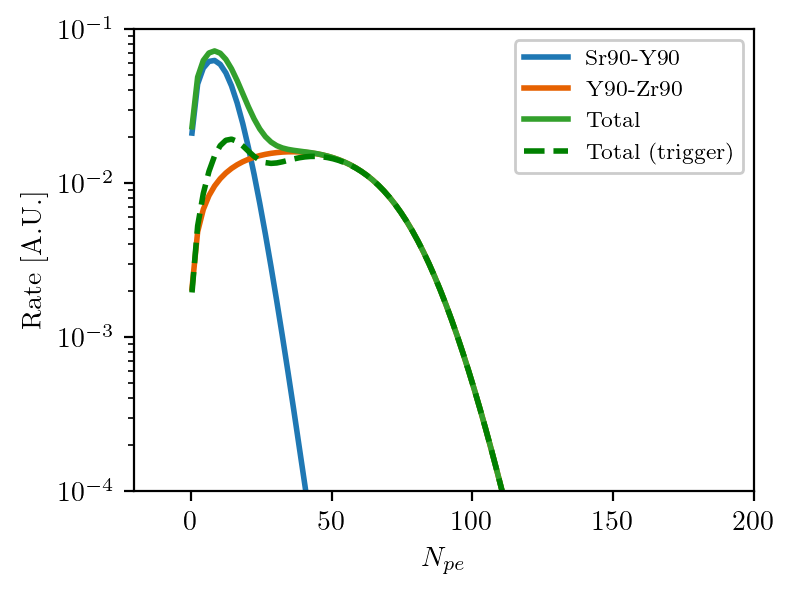

In [3]:
enf = 1.5
lyp = 20/500
npe = np.linspace(0.5, 1000, 500)
norm_sr90, _ = beta.beta_shape_norm(Q=const.Q_SR90, Z=const.Z_Y90, A=const.A_SR90, u1f=True)
norm_y90, _ = beta.beta_shape_norm(Q=const.Q_Y90, Z=const.Z_ZR90, A=const.A_SR90, u1f=True)
plt.figure(1)
plt.plot(npe, [beta.beta_spectrum(Npe=npe_, C=1/norm_sr90, gamma=enf, Lyp=lyp, Q=const.Q_SR90, Z=const.Z_Y90, A=const.A_SR90, u1f=True) for npe_ in npe], label='Sr90-Y90')
plt.plot(npe, [beta.beta_spectrum(Npe=npe_, C=1/norm_y90, gamma=enf, Lyp=lyp, Q=const.Q_Y90, Z=const.Z_ZR90, A=const.A_SR90, u1f=True) for npe_ in npe], label='Y90-Zr90')
plt.plot(npe, [beta.beta_spectrum(Npe=npe_, C=1/norm_sr90, gamma=enf, Lyp=lyp, Q=const.Q_SR90, Z=const.Z_Y90, A=const.A_SR90, u1f=True)+beta.beta_spectrum(Npe=npe_, C=1/norm_y90, gamma=enf, Lyp=lyp, Q=const.Q_Y90, Z=const.Z_ZR90, A=const.A_SR90, u1f=True) for npe_ in npe], label='Total')
plt.plot(npe, [beta.trigger_eff(Npe=npe_, N0=20, B=20)*(beta.beta_spectrum(Npe=npe_, C=1/norm_sr90, gamma=enf, Lyp=lyp, Q=const.Q_SR90, Z=const.Z_Y90, A=const.A_SR90, u1f=True)+beta.beta_spectrum(Npe=npe_, C=1/norm_y90, gamma=enf, Lyp=lyp, Q=const.Q_Y90, Z=const.Z_ZR90, A=const.A_SR90, u1f=True)) for npe_ in npe], 'g--', label='Total (trigger)')
plt.legend(loc='upper right')
plt.yscale('log')
plt.ylim(1e-4, 1e-1)
plt.xlim(-20, 200)
plt.xlabel(r'$N_{pe}$')
plt.ylabel('Rate [A.U.]')

# Scintillation data top 1006

## Directory

In [2]:
dir1006 = "/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/"
subdir1006 = ["2022-10-06/2022-10-06_volt:65_pos:top_light:scint_cond:prepurification/",
              "2022-10-06/2022-10-06_volt:65_pos:top_light:scint_cond:postpurification_1/",
              "2022-10-06/2022-10-06_volt:65_pos:top_light:scint_cond:postpurification_2/",
              "2022-10-06/2022-10-06_volt:65_pos:top_light:scint_cond:postpurification_3/"]
dscrp1006 = ["pre","post1","post2","post3"]

In [3]:
ds1006 = []
for subdir in subdir1006:
    path = "{}{}".format(dir1006, subdir)
    data = ds.Dataset(path, pol=-1, channels=range(4), bias=65, pos='top')
    for ch in range(4):
        print(data.ch[ch].file)
        data.ch[ch].read_data()
        data.ch[ch].baseline_subtraction()
        data.ch[ch].get_avgwf()
        data.ch[ch].get_integral(length=7)
        data.ch[ch].clear()
    data.get_summed_integral_pe()
    ds1006.append(data)

/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-10-06/2022-10-06_volt:65_pos:top_light:scint_cond:prepurification/wave0.dat
WAVEFORM LENGTH = 3000 SAMPLES
TRIGGER POSITION = SAMPLE 1178
NUMBER OF WAVEFORMS = 163183
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-10-06/2022-10-06_volt:65_pos:top_light:scint_cond:prepurification/wave1.dat
WAVEFORM LENGTH = 3000 SAMPLES
TRIGGER POSITION = SAMPLE 1178
NUMBER OF WAVEFORMS = 163183
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-10-06/2022-10-06_volt:65_pos:top_light:scint_cond:prepurification/wave2.dat
WAVEFORM LENGTH = 3000 SAMPLES
TRIGGER POSITION = SAMPLE 1178
NUMBER OF WAVEFORMS = 163183
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-10-06/2022-10-06_volt:65_pos:top_light:scint_cond:prepurification/wave3.dat
WAVEFORM LENGTH = 3000 SAMPLES
TRIGGER POSITION = SAMPLE 1176
NUMBER OF WAVEFORMS = 163183
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-10-06/2022-10-06_volt:65_pos:top_light:scint_cond:po

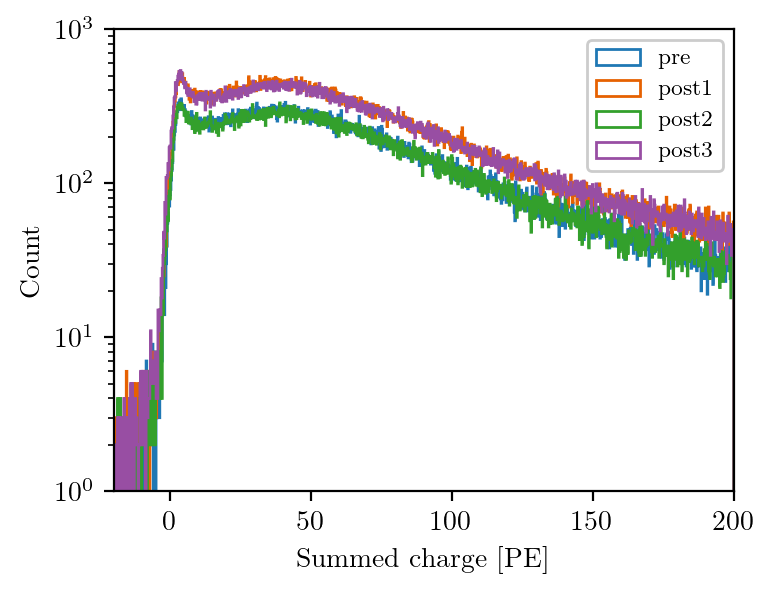

In [4]:
xmin = -20
xmax = 200
nbins = 1000
plt.figure()
labels = ['pre', 'post_1', 'post_2', 'post_3']
for i,ds in enumerate(ds1006):
    plt.hist(ds.summed_integral_pe, bins=np.linspace(xmin,xmax,nbins), histtype='step', label=dscrp1006[i])
plt.yscale('log')
plt.legend(loc='upper right')
plt.xlim(xmin, xmax)
plt.xlabel('Summed charge [PE]')
plt.ylabel('Count')
plt.show()

## Triplet lifetime

ch0 A_S=324.704+/-4.453  TAU_S=0.0444+/-0.0007us  A_T=43.041+/-0.252  TAU_T=1.1143+/-0.0066us
ch1 A_S=291.244+/-3.089  TAU_S=0.0555+/-0.0007us  A_T=42.490+/-0.266  TAU_T=1.1900+/-0.0073us
ch2 A_S=299.672+/-3.176  TAU_S=0.0485+/-0.0006us  A_T=40.445+/-0.197  TAU_T=1.2012+/-0.0059us
ch3 A_S=270.784+/-2.746  TAU_S=0.0579+/-0.0007us  A_T=36.422+/-0.233  TAU_T=1.2126+/-0.0075us
ch0 A_S=322.899+/-4.376  TAU_S=0.0446+/-0.0007us  A_T=42.731+/-0.247  TAU_T=1.1234+/-0.0066us
ch1 A_S=288.319+/-3.030  TAU_S=0.0560+/-0.0007us  A_T=41.890+/-0.260  TAU_T=1.2076+/-0.0073us
ch2 A_S=298.173+/-3.134  TAU_S=0.0487+/-0.0006us  A_T=40.047+/-0.193  TAU_T=1.2203+/-0.0060us
ch3 A_S=269.837+/-2.730  TAU_S=0.0578+/-0.0007us  A_T=36.182+/-0.228  TAU_T=1.2252+/-0.0075us
ch0 A_S=326.464+/-4.377  TAU_S=0.0445+/-0.0007us  A_T=43.130+/-0.241  TAU_T=1.1489+/-0.0065us
ch1 A_S=291.270+/-3.057  TAU_S=0.0560+/-0.0007us  A_T=42.470+/-0.258  TAU_T=1.2291+/-0.0073us
ch2 A_S=300.614+/-3.170  TAU_S=0.0485+/-0.0006us  A_T=40.753

([<matplotlib.axis.XTick at 0x1549c1b0d9d0>,
 [Text(0, 0, 'pre'),
  Text(1, 0, 'post1'),
  Text(2, 0, 'post2'),
  Text(3, 0, 'post3')])

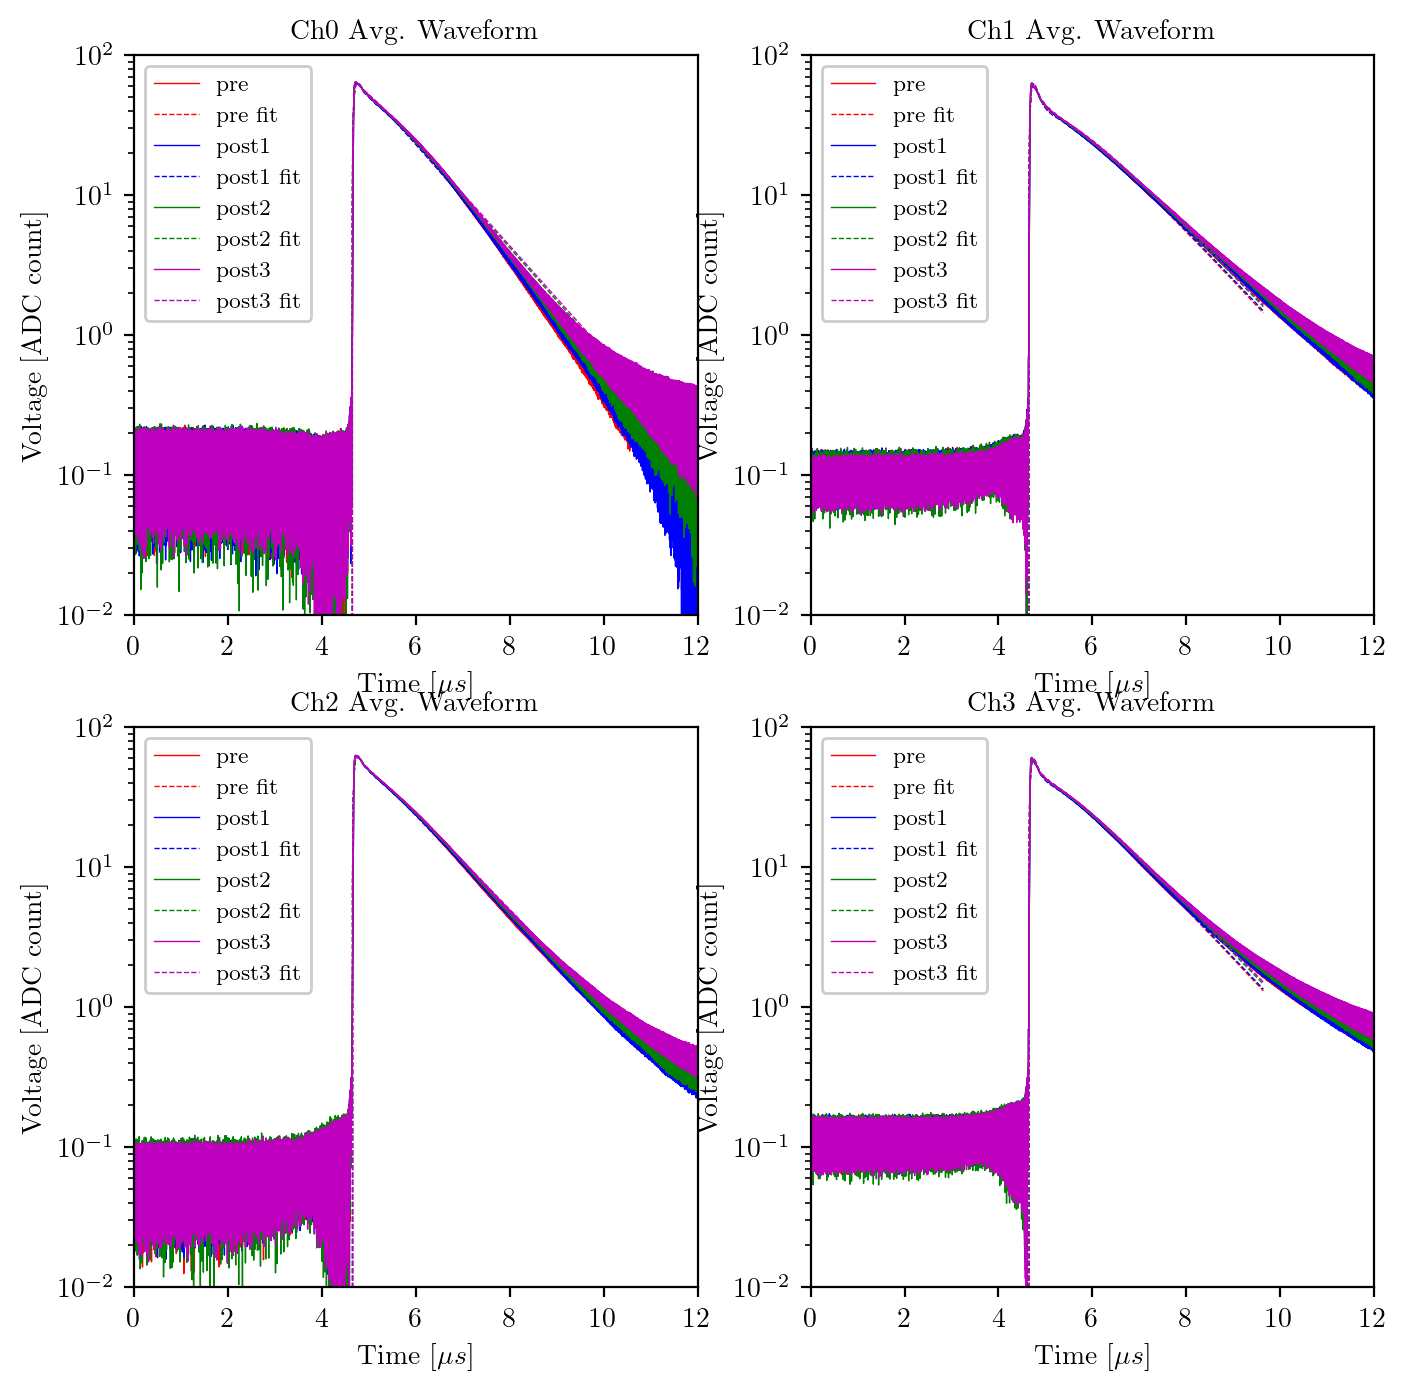

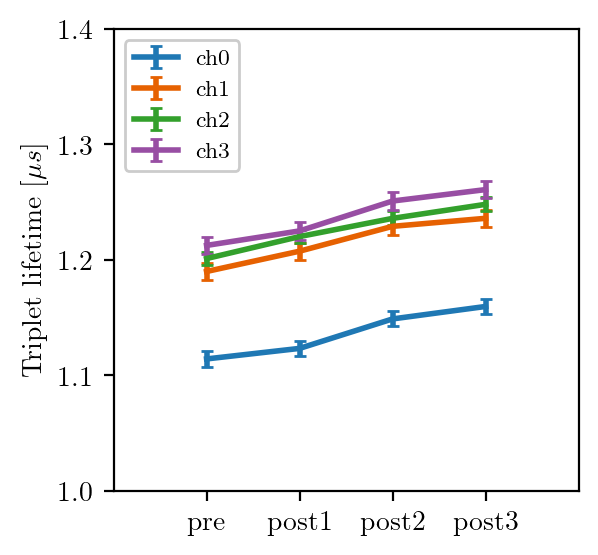

In [14]:
plt.figure(0,figsize=(8,8))
colors = ['r','b','g','m']
A1 = [2.350, 4.464, 2.919, 4.302]
TAU1 = [0.05331, 0.09480, 0.06779, 0.07185]
A2 = [3.412, 1.193, 2.925, 1.794]
TAU2 = [0.34460, 0.67362, 0.37612, 0.56386]

for i,ds in enumerate(ds1006):
    for ch in range(4):
        ds.ch[ch].set_pulse_pars(a1=A1[ch], tau1=TAU1[ch], a2=A2[ch], tau2=TAU2[ch])
        plt.subplot(2,2,ch+1)
        plt.plot(ds.ch[ch].time, abs(ds.ch[ch].avgwf), "{}-".format(colors[i]), label=dscrp1006[i], linewidth=0.5)      
        t0 = ds.ch[ch].trigger_position
        length = int(5/ds.ch[ch].sample_step)
        err = np.std(ds.ch[ch].avgwf[:t0])
        popt,pcov = curve_fit(ds.ch[ch].get_scintillation, ds.ch[ch].time[t0:t0+length], abs(ds.ch[ch].avgwf[t0:t0+length]), p0=[300, 0.05, 40, 1.2], sigma=[err]*length, maxfev=10000)
        print('ch{} A_S={:.3f}+/-{:.3f}  TAU_S={:.4f}+/-{:.4f}us  A_T={:.3f}+/-{:.3f}  TAU_T={:.4f}+/-{:.4f}us'.format(ch,popt[0],np.sqrt(pcov[0,0]),popt[1],np.sqrt(pcov[1,1]),popt[2],np.sqrt(pcov[2,2]),popt[3],np.sqrt(pcov[3,3])))
        ds.ch[ch].tau_singlet = [popt[1], np.sqrt(pcov[1,1])]
        ds.ch[ch].tau_triplet = [popt[3], np.sqrt(pcov[3,3])]
        plt.plot(ds.ch[ch].time[t0:t0+length], ds.ch[ch].get_scintillation(ds.ch[ch].time[t0:t0+length], *popt), "{}--".format(colors[i]), label='{} fit'.format(dscrp1006[i]), linewidth=0.5)
        # plt.plot(ds.ch[ch].time[t0:t0+length], ds.ch[ch].get_scintillation(ds.ch[ch].time[t0:t0+length], 100, 8e-2, 50, 1.1), "{}--".format(colors[i]), label='{} fit'.format(dscrp1006[i]), linewidth=0.5)

for ch in range(4):
    plt.subplot(2,2,ch+1)
    plt.title('Ch{} Avg. Waveform'.format(ch))
    plt.ylabel('Voltage [ADC count]')
    plt.xlabel(r'Time [$\mu s$]')
    plt.legend()
    plt.xlim(0,12)
    plt.ylim(1e-2, 100)
    plt.yscale('log')

plt.figure(1, figsize=(3,3))
for ch in range(4):
    plt.errorbar(np.arange(4), [ds.ch[ch].tau_triplet[0] for ds in ds1006], yerr=[ds.ch[ch].tau_triplet[1] for ds in ds1006], label='ch{}'.format(ch))
plt.xlim(-1, 4)
plt.ylim(1, 1.4)
plt.legend()
plt.ylabel(r'Triplet lifetime [$\mu s$]')
plt.xticks(np.arange(4),labels=dscrp1006)

# Scintillation data top 1007

In [37]:
data_dir = "/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-10-07/"
subdir = ["2022-10-07_volt_65_pos_top_light_scint_coinc_111",
          "2022-10-07_volt_67_pos_top_light_scint_coinc_111",
          "2022-10-07_volt_69_pos_top_light_scint_coinc_111",
          "2022-10-07_volt_71_pos_top_light_scint_coinc_111",
          "2022-10-07_volt_73_pos_top_light_scint_coinc_111",
          "2022-10-07_volt_75_pos_top_light_scint_coinc_111"]

In [ ]:
datasets_1007 = []
for subdir_ in subdir:
    dataset
    for j in range(10):
        avgwf_ch = []
        path = "{}{}/{}_{}/".format(data_dir, subdir_, subdir_,j)
        data = ds.Dataset(path, pol=-1, channels=range(4))
        for i in range(4):
            print(data.ch[i].file)
            print("Analyzing channel {}".format(i))
            data.ch[i].read_data()
            data.ch[i].baseline_subtraction()
            data.ch[i].get_avgwf()
            avgwf_ch.append(data.ch[i].avgwf)
            data.ch[i].get_integral()
            data.ch[i].clear()
            if i==0:
                time_datasets_1007.append(data.ch[i].time)
        #merge data

    avgwf_datasets_1007.append(avgwf_ch)
    data.get_summed_integral_pe()
    summed_integral_pe_datasets_1007.append(data.summed_integral_pe)
    print("summed charge")


In [ ]:
xmin = -50
xmax = 500
nbins = 200
plt.figure()
merge_integral = []
for i,integral in enumerate(summed_integral_pe_datasets_1007):
    merge_integral = merge_integral + list(integral)
plt.hist(merge_integral, bins=np.linspace(xmin,xmax,nbins), histtype='step')
plt.yscale('log')
plt.xlim(xmin, xmax)
plt.xlabel('Summed charge [PE]')
plt.ylabel('Count')
plt.show()

In [ ]:
plt.figure(0,figsize=(9,9))
avgwf_overall = np.zeros((4,np.shape(avgwf_datasets_1007)[2]))
for ch in range(4):
    plt.subplot(2,2,ch+1)
    plt.title('Ch{} Avg. Waveform'.format(ch))
    plt.ylabel('Voltage [ADC count]')
    plt.xlabel(r'Time [$\mu s$]')
    for i,avgwf in enumerate(avgwf_datasets_1007):
        avgwf_overall[ch] = np.mean(np.array(avgwf_datasets_1007)[:,ch,:], axis=0)
    plt.plot(time_datasets_1007[0], abs(avgwf_overall[ch]), '-', label = '10-07', linewidth=0.5)
    trig_pos = np.argmax(avgwf_overall[ch])
    trig_height = np.max(avgwf_overall[ch])
    popt,pcov = curve_fit(expo_scint, time_datasets_1007[0][trig_pos+100:trig_pos+600], avgwf_overall[ch][trig_pos+100:trig_pos+600], p0=[trig_height/np.exp(-trig_pos*4e-3/1.5),1.5],maxfev=10000)
    print(r'A={}  TAU={} us$'.format(popt[0],popt[1]))
    tau_ch_datasets[ch].append(popt[1])
    plt.plot(time_datasets_1007[0][trig_pos+100:trig_pos+600], expo_scint(time_datasets_1007[0][trig_pos+100:trig_pos+600], *popt), "--", label='10-07 fit', linewidth=0.5)

    plt.xlim(0,12)
    plt.ylim(1e-2, 200)
    plt.yscale('log')

In [ ]:
plt.figure()
for ch in range(4):
    plt.scatter(np.arange(len(tau_ch_datasets[ch])), tau_ch_datasets[ch],label='ch{}'.format(ch))
plt.ylabel(r'$\tau~[\mu s]$')
plt.xticks(np.arange(len(tau_ch_datasets[ch])),labels=['pre','post1','post2','post3','10-07'])
plt.xlim(-1,5)
plt.legend()